# Importing the packages

In [8]:
#import sys
#!{sys.executable} -m pip install sklearn.utils

In [9]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
sys.path.append(os.path.abspath('..'))
# from hmm_class.hmmd_scaled import HMM

import nltk
#nltk.download()
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.tokenize import TweetTokenizer

lancaster_stemmer = LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
tknzr = TweetTokenizer(preserve_case=True, strip_handles=False, reduce_len=False)
stop = set(stopwords.words('english'))

import itertools
from sklearn.utils import shuffle
from datetime import datetime
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.externals import joblib

# Function for getting the word and NER tag pairs

In [10]:
def get_tuples(dspath):
    sentences = []
    s = ''
    tokens = []
    ners = []
    poss = []
    tot_sentences = 0
    ners_by_position = []
    index = 0
    with open(dspath) as f:
        for line in f:
            if line.strip() != '':
                token = line.split('\t')[0].decode('utf-8')
                ner = line.split('\t')[1].replace('\r', '').replace('\n', '').decode('utf-8')
                '''
                if ner in definitions.NER_TAGS_ORG:
                    ner = 'ORG'
                elif ner in definitions.NER_TAGS_LOC:
                    ner = 'LOC'
                elif ner in definitions.NER_TAGS_PER:
                    ner = 'PER'
                else :
                    ner = 'O'
                '''
                #ners_by_position.append([index, len(token), ner])
                index += len(token) + 1
            if line.strip() == '':
                if len(tokens) != 0:
                    #poss = [x[1].decode('utf-8') for x in nltk.pos_tag(nltk.word_tokenize(s[:-1]))]
                    poss = [x[1].decode('utf-8') for x in nltk.pos_tag(tknzr.tokenize(s[:-1]))]


                    #if len(poss) == len(tokens): # tokenization doesnt affect position of NERs, i.e., same tokenization
                    sentences.append(zip(tokens, poss, ners))
                    #else:
                    #    aux = 0
                    #    for i in range(len()):
                    #        if aux <= tokens[i]

                    tokens = []
                    ners = []
                    s = ''
                    tot_sentences += 1
            else:
                s += token + ' '
                tokens.append(token)
                ners.append(ner)

    return sentences


# Functions to creating the feature vectors from the wrods and applying the classification on them

In [12]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1].encode("utf-8")

    #my addition
    ner_class = sent[i][2].encode("utf-8")

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2].encode("utf-8"),
        'stop_word': word in stop,
        'hyphen': '-' in word,
        'size_small': True if len(word) <= 2 else False,
        'stemmer_lanc': lancaster_stemmer.stem(word),

    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1].encode("utf-8")
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2].encode("utf-8"),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1].encode("utf-8")
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2].encode("utf-8"),
        })
    else:
        features['EOS'] = True

    return features

def word2features_new(sent, i):
    word = sent[i][0]
    postag = sent[i][1].encode("utf-8")
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2].encode("utf-8"),
        'stop_word': word in stop,
        'hyphen': '-' in word,
        'size_small': True if len(word) <= 2 else False,
        'stemmer_lanc': lancaster_stemmer.stem(word),
        'klass_1': tf_idf_clone_1.predict([word])[0],
        'klass': tf_idf_clone.predict([word])[0],
        'klass_2': tf_idf_clone_2.predict([word])[0],
        'klass_3': tf_idf_clone_3.predict([word])[0],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1].encode("utf-8")
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2].encode("utf-8"),
            '-1:klass': tf_idf_clone.predict([word])[0],
            '-1:klass_1': tf_idf_clone_1.predict([word])[0],
            '-1:klass_2': tf_idf_clone_2.predict([word])[0],
            '-1:klass_3': tf_idf_clone_3.predict([word])[0],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1].encode("utf-8")
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2].encode("utf-8"),
            '+1:klass': tf_idf_clone.predict([word])[0],
            '+1:klass_1': tf_idf_clone_1.predict([word])[0],
            '+1:klass_2': tf_idf_clone_2.predict([word])[0],
            '+1:klass_3': tf_idf_clone_3.predict([word])[0],
        })
    else:
        features['EOS'] = True

    return features


def remove_extra_features(X_train_new, X_test_new):
    X_train = []
    X_test = []
    for sentence in X_train_new:
        tmp = []
        for token in sentence:
            del token['klass']
            del token['klass_1']
            del token['klass_2']
            del token['klass_3']

            if '+1:klass' in token:
                del token['+1:klass']
                del token['+1:klass_1']
                del token['+1:klass_2']
                del token['+1:klass_3']

            if '-1:klass' in token:
                del token['-1:klass']
                del token['-1:klass_1']
                del token['-1:klass_2']
                del token['-1:klass_3']
            tmp.append(token)
            X_train.append(tmp)

    for sentence in X_test_new:
            tmp = []
            for token in sentence:

                del token['klass']
                del token['klass_1']
                del token['klass_2']
                del token['klass_3']

                if '+1:klass' in token:
                    del token['+1:klass']
                    del token['+1:klass_1']
                    del token['+1:klass_2']
                    del token['+1:klass_3']

                if '-1:klass' in token:
                    del token['-1:klass']
                    del token['-1:klass_1']
                    del token['-1:klass_2']
                    del token['-1:klass_3']
                tmp.append(token)
                X_test.append(tmp)

    return X_train, X_test

def group_labels(labels):
    y = []
    for string in labels:
        temp = []
        for tok in string:
            if tok.find("geo-loc") != -1 or tok.find("location") != -1:
                temp.append("LOC")
            elif tok.find("company") != -1 or tok.find("corporation") != -1:
                temp.append("ORG")
            elif tok.find("person") != -1:
                temp.append("PER")
            else:
                temp.append("O")

        y.append(temp)

    return y


def group_labels_num(labels):
    y = []
    for string in labels:
        temp = []
        for tok in string:
            if tok == 1:
                temp.append("LOC")
            elif tok == 2:
                temp.append("ORG")
            elif tok == 3:
                temp.append("PER")
            else:
                temp.append("O")

        y.append(temp)

    return y


In [13]:
def sent2features(sent):
    return [word2features_new(sent, i) for i in range(len(sent))]


def sent2labels(sent):
    return [label.encode("utf-8") for token, postag, label in sent]


def sent2tokens(sent):
    return [token for token, postag, label in sent]
#print("i am here1")


# Importing the before created dataset (saves time)

In [14]:
tf_idf_clone_1 = joblib.load('tf-idf+svm_1.pkl')
tf_idf_clone_2 = joblib.load('tf-idf+svm_2.pkl')
tf_idf_clone_3 = joblib.load('tf-idf+svm_3.pkl')
tf_idf_clone = joblib.load('tf-idf+svm_new.pkl')



X_train = joblib.load('X_train.pkl')
X_train_new = joblib.load('X_train_new.pkl')
y_train = joblib.load('y_train.pkl')

X_test = joblib.load('X_test.pkl')
X_test_new = joblib.load('X_test_new.pkl')
y_test = joblib.load('y_test.pkl')


# The HMM part - First getting the frequencies of the different entities

In [15]:
def get_data(train, labels, test,testy, split_sequences=False):
    # if not os.path.exists('chunking'):
    #     print("Please create a folder in your local directory called 'chunking'")
    #     print("train.txt and test.txt should be stored in there.")
    #     print("Please check the comments to get the download link.")
    #     exit()
    # elif not os.path.exists('chunking/train.txt'):
    #     print("train.txt is not in chunking/train.txt")
    #     print("Please check the comments to get the download link.")
    #     exit()
    # elif not os.path.exists('chunking/test.txt'):
    #     print("test.txt is not in chunking/test.txt")
    #     print("Please check the comments to get the download link.")
    #     exit()

    word2idx = {}
    tag2idx = {}
    word_idx = 0
    tag_idx = 0
    Xtrain = []
    Ytrain = []
    currentX = []
    currentY = []
    

    for line1,line2 in itertools.izip(train,labels):
        #print("line")
        #print(line)
        # line = line.rstrip()
        # here should I iterate the list with the lenght and number to get the labels
        for pair1,pair2 in itertools.izip(line1,line2):

            #if pair:
                #print("class")
                #r = line.split()

            word = tuple(pair1.values())
            tag = pair2
            #print(tag)
            #word, tag = r
            if word not in word2idx:
                word2idx[word] = word_idx
                word_idx += 1
            currentX.append(word2idx[word])

            if tag not in tag2idx:
                tag2idx[tag] = tag_idx
                tag_idx += 1
            currentY.append(tag2idx[tag])
        if split_sequences:
            Xtrain.append(currentX)
            Ytrain.append(currentY)
            currentX = []
            currentY = []


    # load and score test data
    Xtest = []
    Ytest = []
    currentX = []
    currentY = []
    for line1,line2 in itertools.izip(test,testy):
        #print("line")
        #print(line)
        # line = line.rstrip()
        # here should I iterate the list with the lenght and number to get the labels
        for pair1,pair2 in itertools.izip(line1,line2):

            #if pair:
                #r = line.split()
            word = tuple(pair1.values())
            tag = pair2#[:2]
            #word, tag, = r
            if word in word2idx:
                currentX.append(word2idx[word])
            else:
                currentX.append(word_idx)  # use this as unknown
            currentY.append(tag2idx[tag])
        if split_sequences:
            Xtest.append(currentX)
            Ytest.append(currentY)
            currentX = []
            currentY = []

    return Xtrain, Ytrain, Xtest, Ytest, word2idx

def random_normalized(d1, d2):
    x = np.random.random((d1, d2))
    return x / x.sum(axis=1, keepdims=True)

# HMM model creation - train the HMM, find the hidden state matrix, create observation matrix, Baum-Welch and Viterbi used

In [16]:
class HMM:
    def __init__(self, M):
        self.M = M  # number of hidden states

    def fit(self, X, max_iter=30):
        np.random.seed(123)
        # train the HMM model using the Baum-Welch algorithm
        # a specific instance of the expectation-maximization algorithm

        # determine V, the vocabulary size
        # assume observables are already integers from 0..V-1
        # X is a jagged array of observed sequences
        V = max(max(x) for x in X) + 1
        N = len(X)

        self.pi = np.ones(self.M) / self.M  # initial state distribution
        self.A = random_normalized(self.M, self.M)  # state transition matrix
        self.B = random_normalized(self.M, V)  # output distribution

        print("initial A:", self.A)
        print("initial B:", self.B)

        costs = []
        for it in range(max_iter):
            if it % 10 == 0:
                print("it:", it)
            # alpha1 = np.zeros((N, self.M))
            alphas = []
            betas = []
            scales = []
            logP = np.zeros(N)
            for n in range(N):
                x = X[n]
                T = len(x)
                scale = np.zeros(T)
                # alpha1[n] = self.pi*self.B[:,x[0]]
                alpha = np.zeros((T, self.M))
                alpha[0] = self.pi * self.B[:, x[0]]
                scale[0] = alpha[0].sum()
                alpha[0] /= scale[0]
                for t in range(1, T):
                    alpha_t_prime = alpha[t - 1].dot(self.A) * self.B[:, x[t]]
                    scale[t] = alpha_t_prime.sum()
                    alpha[t] = alpha_t_prime / scale[t]
                logP[n] = np.log(scale).sum()
                alphas.append(alpha)
                scales.append(scale)

                beta = np.zeros((T, self.M))
                beta[-1] = 1
                for t in range(T - 2, -1, -1):
                    beta[t] = self.A.dot(self.B[:, x[t + 1]] * beta[t + 1]) / scale[t + 1]
                betas.append(beta)

            cost = np.sum(logP)
            costs.append(cost)

            # now re-estimate pi, A, B
            self.pi = np.sum((alphas[n][0] * betas[n][0]) for n in range(N)) / N

            den1 = np.zeros((self.M, 1))
            den2 = np.zeros((self.M, 1))
            a_num = np.zeros((self.M, self.M))
            b_num = np.zeros((self.M, V))
            for n in range(N):
                x = X[n]
                T = len(x)
                den1 += (alphas[n][:-1] * betas[n][:-1]).sum(axis=0, keepdims=True).T
                den2 += (alphas[n] * betas[n]).sum(axis=0, keepdims=True).T

                # numerator for A
                # a_num_n = np.zeros((self.M, self.M))
                for i in range(self.M):
                    for j in range(self.M):
                        for t in range(T - 1):
                            a_num[i, j] += alphas[n][t, i] * betas[n][t + 1, j] * self.A[i, j] * self.B[j, x[t + 1]] / \
                                           scales[n][t + 1]
                # a_num += a_num_n

                # numerator for B
                # for i in range(self.M):
                #     for j in range(V):
                #         for t in range(T):
                #             if x[t] == j:
                #                 b_num[i,j] += alphas[n][t][i] * betas[n][t][i]
                for i in range(self.M):
                    for t in range(T):
                        b_num[i, x[t]] += alphas[n][t, i] * betas[n][t, i]
            self.A = a_num / den1
            self.B = b_num / den2
        print("A:", self.A)
        print("B:", self.B)
        print("pi:", self.pi)

        #plt.plot(costs)
        #plt.show()

    def log_likelihood(self, x):
        # returns log P(x | model)
        # using the forward part of the forward-backward algorithm
        T = len(x)
        scale = np.zeros(T)
        alpha = np.zeros((T, self.M))
        alpha[0] = self.pi * self.B[:, x[0]]
        scale[0] = alpha[0].sum()
        alpha[0] /= scale[0]
        for t in range(1, T):
            alpha_t_prime = alpha[t - 1].dot(self.A) * self.B[:, x[t]]
            scale[t] = alpha_t_prime.sum()
            alpha[t] = alpha_t_prime / scale[t]
        return np.log(scale).sum()

    def log_likelihood_multi(self, X):
        return np.array([self.log_likelihood(x) for x in X])

    def get_state_sequence(self, x):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        T = len(x)
        delta = np.zeros((T, self.M))
        psi = np.zeros((T, self.M))
        #print(x)
        delta[0] = np.log(self.pi) + np.log(self.B[:, x[0]])
        for t in range(1, T):
            for j in range(self.M):
                delta[t, j] = np.max(delta[t - 1] + np.log(self.A[:, j])) + np.log(self.B[j, x[t]])
                psi[t, j] = np.argmax(delta[t - 1] + np.log(self.A[:, j]))

        # backtrack
        states = np.zeros(T, dtype=np.int32)
        states[T - 1] = np.argmax(delta[T - 1])
        for t in range(T - 2, -1, -1):
            states[t] = psi[t + 1, states[t + 1]]
        return states

# Evaluation metrics - Accuracy, F1-Score and Confusion Matrix

In [17]:
def accuracy(T, Y):
    # inputs are lists of lists
    n_correct = 0
    n_total = 0
    for t, y in zip(T, Y):
        #print("miamano")
        #print(t,y)
        for x, z in zip(t, y):
            if x != 0:
                if x == z:
                    n_correct += 1
                n_total += 1
        #n_correct += np.sum(t == y)
        #print("The sum", np.sum(t == y))
        #n_total += len(y)
    return float(n_correct) / n_total


def total_f1_score(T, Y, labels):
    # inputs are lists of lists
    

    T = np.concatenate(T)
    Y = np.concatenate(Y)
    #print("Try to remove: ", labels)
    labels.discard(0)
    return f1_score(T, Y, labels=list(labels), average=None).mean()

def total_conf_matrix(T, Y):
    # inputs are lists of lists
    T = np.concatenate(T)
    Y = np.concatenate(Y)
    return confusion_matrix(T, Y)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()

# Creating HMM class and getting the prediction and evaluate

('test accuracy:', 0.3224990971469845)
('test f1:', 0.01489244875951023)


/usr/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Normalized confusion matrix


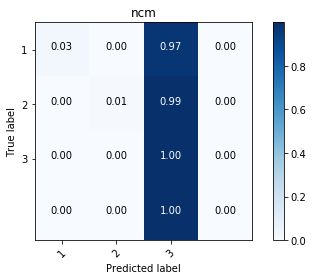

In [18]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def main( X_train, y_train, X_test, y_test, smoothing=1e-4):
    # X = words, Y = POS tags
    Xtrain, Ytrain, Xtest, Ytest, word2idx = get_data(X_train, y_train, X_test,y_test, split_sequences=True)
    V = len(word2idx) + 1

    # find hidden state transition matrix and pi
    M = max(max(y) for y in Ytrain) + 1 #len(set(flatten(Ytrain)))
    A = np.ones((M, M))*smoothing # add-one smoothing
    pi = np.zeros(M)
    for y in Ytrain:
        pi[y[0]] += 1
        for i in range(len(y)-1):
            A[y[i], y[i+1]] += 1
    # turn it into a probability matrix
    A /= A.sum(axis=1, keepdims=True)
    pi /= pi.sum()

    # find the observation matrix
    B = np.ones((M, V))*smoothing # add-one smoothing
    for x, y in zip(Xtrain, Ytrain):
        for xi, yi in zip(x, y):
            B[yi, xi] += 1
    B /= B.sum(axis=1, keepdims=True)

    hmm = HMM(M)
    hmm.pi = pi
    hmm.A = A
    hmm.B = B

    # get predictions
    Ptrain = []
    for x in Xtrain:
        p = hmm.get_state_sequence(x)
        Ptrain.append(p)

    Ptest = []
    #print(hmm.get_state_sequence(Xtrain[0]))
    #print(Xtrain[0])
    p = hmm.get_state_sequence(Xtrain[0])
    #print(p)
    for x in Xtest:
        if x:
            p = hmm.get_state_sequence(x)
            Ptest.append(p)
    labels=set(flatten(Ytest))
    #print(labels)
    
    # print results
    #print("train accuracy:", accuracy(Ytrain, Ptrain))
    print("The test accuracy and F1-Score:")
    print("*********************************************************************")
    print("test accuracy:", accuracy(Ytest, Ptest))
    print("*********************************************************************")
    #print("train f1:", total_f1_score(Ytrain, Ptrain, labels))
    print("test f1:", total_f1_score(Ytest, Ptest, labels))
    
    cnf_matrix = total_conf_matrix(Ytest, Ptest)
    plt.figure()

    plot_confusion_matrix(cnf_matrix,classes=list(labels), normalize=True,
                          title='ncm')

    plt.show()

main( X_train_new, y_train, X_test_new, y_test)